## **Bidirectional LSTMs with Attention**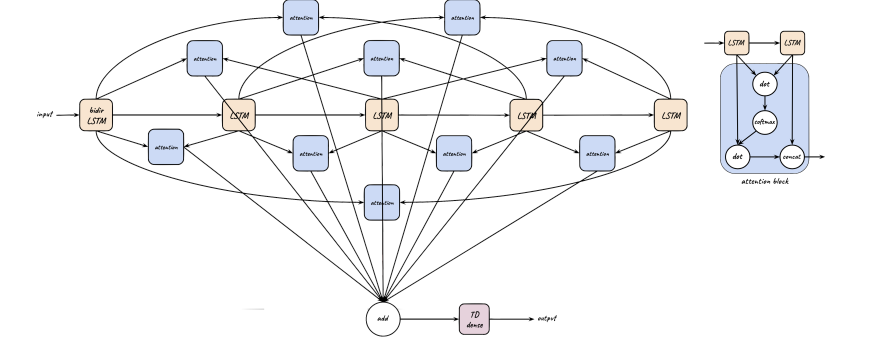

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.metrics import categorical_accuracy
from keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from datetime import datetime
import os, pickle
from utils import *

In [ ]:
class DataLoader:
    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self, filename):
        try:
            return np.load(self.filepath + filename)
        except FileNotFoundError:
            print(f"File {filename} not found.")
        except Exception as e:
            print(f"An error occurred: {e}")
        return None


In [ ]:
class DataProcessor:
    def __init__(self, residue_list, q8_list, f, r):
        self.residue_list = residue_list
        self.q8_list = q8_list
        self.f = f
        self.r = r

    def process_data(self, arr):
        if arr is None:
            return None
        data = []
        try:
            for idx, entry in enumerate(arr):
                seq, q8, profiles = '', '', []
                for j in range(self.r):
                    jf = j * self.f
                    residue_onehot = entry[jf:jf+22]
                    residue = self.residue_list[np.argmax(residue_onehot)]
                    residue_q8_onehot = entry[jf+22:jf+31]
                    residue_q8 = self.q8_list[np.argmax(residue_q8_onehot)]
                    if residue == 'NoSeq':
                        break
                    profile = entry[jf+35:jf+57]
                    seq += residue
                    q8 += residue_q8
                    profiles.append(profile)
                data.append([str(idx+1), len(seq), seq, np.array(profiles), q8])
            return pd.DataFrame(data, columns=["id", "len", "input", "profiles", "expected"])
        except Exception as e:
            print(f"Error processing data: {str(e)}")
        return None

In [ ]:
class ModelTrainer:
    def __init__(self, n_words, n_tags, maxlen_seq):
        self.n_words = n_words
        self.n_tags = n_tags
        self.maxlen_seq = maxlen_seq

    def train(self, X_train, y_train, X_val=None, y_val=None):
        try:
            model = self.build_model()
            model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy", self.accuracy])
            history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val) if X_val is not None else None)
            return history, model
        except Exception as e:
            print(f"Failed to train model: {e}")
        return None, None

    def accuracy(self, y_true, y_pred):
        try:
            y = tf.argmax(y_true, axis=-1)
            y_ = tf.argmax(y_pred, axis=-1)
            mask = tf.greater(y, 0)
            return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())
        except Exception as e:
            print(f"Failed to compute accuracy: {e}")
            return None

    def build_model(self):
        try:
            inp = Input(shape=(self.maxlen_seq, self.n_words))
            inp_alt = Input(shape=(self.maxlen_seq,))
            inp_profiles = Input(shape=(self.maxlen_seq, 22))
            x_emb = Embedding(input_dim=self.n_words, output_dim=64, input_length=self.maxlen_seq)(inp_alt)
            x = Concatenate(axis=-1)([inp, x_emb, inp_profiles])
            x = self.conv_block(x)
            x = Bidirectional(CuDNNGRU(units=256, return_sequences=True, recurrent_regularizer=l2(0.2)))(x)
            x = TimeDistributed(Dropout(0.5))(x)
            x = TimeDistributed(Dense(256, activation="relu"))(x)
            x = TimeDistributed(Dropout(0.5))(x)
            y = TimeDistributed(Dense(self.n_tags, activation="softmax"))(x)
            return Model([inp, inp_alt, inp_profiles], y)
        except Exception as e:
            print(f"Failed to build model: {e}")
            return None

    def conv_block(self, x):
        try:
            cnn = Conv1D(64, 11, padding="same")(x)
            cnn = Activation("relu")(cnn)
            cnn = BatchNormalization()(cnn)
            cnn = Dropout(0.5)(cnn)
            return Concatenate(axis=-1)([x, cnn])
        except Exception as e:
            print(f"Failed to create convolution block: {e}")
            return x

In [ ]:


class PredictionRunner:
    def __init__(self, model, tokenizer_encoder, tokenizer_decoder):
        self.model = model
        self.tokenizer_encoder = tokenizer_encoder
        self.tokenizer_decoder = tokenizer_decoder

    def run_test(self, test_input_data, test_profiles, csv_name, npy_name):
        try:
            y_test_pred = self.model.predict([test_input_data, test_input_data, test_profiles])
            reverse_decoder_index = {value: key for key, value in self.tokenizer_decoder.word_index.items()}
            decoded_y_pred = [self.decode_results(y, reverse_decoder_index) for y in y_test_pred]
            out_df = pd.DataFrame({"id": range(1, len(decoded_y_pred)+1), "expected": decoded_y_pred})
            out_df.to_csv(csv_name, index=False)
            np.save(npy_name, y_test_pred)
        except Exception as e:
            print(f"Failed to run prediction: {e}")

    def decode_results(self, y_, reverse_decoder_index):
        try:
            sequence = ''.join([reverse_decoder_index[np.argmax(o)] for o in y_ if np.argmax(o) != 0])
            return sequence.upper()
        except Exception as e:
            print(f"Failed to decode results: {e}")
            return None


## **Bidirectional GRU with Convolutional Blocks.**

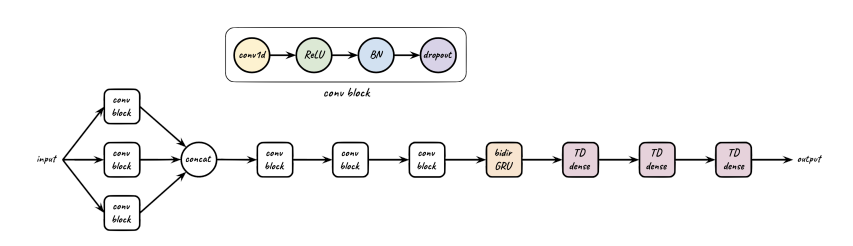

In [ ]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Embedding, Dense, TimeDistributed, Concatenate, BatchNormalization
from keras.layers import Bidirectional, Activation, Dropout, CuDNNGRU, Conv1D

from sklearn.model_selection import train_test_split, KFold
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.regularizers import l1, l2
import tensorflow as tf

In [ ]:


class ProteinSequencePredictor:
    def __init__(self, filtered_file_path, test_file_path, log_directory_base='../logs'):
        self.filtered_file_path = filtered_file_path
        self.test_file_path = test_file_path
        self.log_directory_base = log_directory_base
        self.max_sequence_length = 768
        self.dropout_rate = 0.3
        self.setup_directories()
        self.load_data()

    def setup_directories(self):
        script_name = os.path.basename(__file__).split(".")[0]
        model_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + script_name
        self.log_directory = os.path.join(self.log_directory_base, model_name)
        if not os.path.exists(self.log_directory):
            os.makedirs(self.log_directory)

    def load_data(self):
        try:
            self.training_dataframe, self.training_augmentation_data = load_augmented_data(self.filtered_file_path, self.max_sequence_length)
            self.testing_dataframe, self.testing_augmentation_data = load_augmented_data(self.test_file_path, self.max_sequence_length)
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def preprocess_data(self):
        try:
            num_samples = len(self.training_dataframe)
            np.random.seed(0)
            validation_indices = np.random.choice(np.arange(num_samples), size=300, replace=False)
            training_indices = np.array(list(set(np.arange(num_samples))-set(validation_indices)))

            self.validation_dataframe = self.training_dataframe.iloc[validation_indices]

            train_input_seqs, train_target_seqs = self.training_dataframe[['input', 'expected']].values.T
            train_input_grams = seq2ngrams(train_input_seqs, n=1)
            self.encoder_tokenizer = Tokenizer()
            self.encoder_tokenizer.fit_on_texts(train_input_grams)
            self.decoder_tokenizer = Tokenizer(char_level=True)
            self.decoder_tokenizer.fit_on_texts(train_target_seqs)

            train_input_data = self.encoder_tokenizer.texts_to_sequences(train_input_grams)
            train_input_data = sequence.pad_sequences(train_input_data, maxlen=self.max_sequence_length, padding='post', truncating='post')
            train_target_data = self.decoder_tokenizer.texts_to_sequences(train_target_seqs)
            train_target_data = sequence.pad_sequences(train_target_data, maxlen=self.max_sequence_length, padding='post', truncating='post')
            train_target_data = to_categorical(train_target_data)

            self.X_val = train_input_data[validation_indices]
            self.X_train = train_input_data[training_indices]
            self.y_val = train_target_data[validation_indices]
            self.y_train = train_target_data[training_indices]
            self.X_train_augment = self.training_augmentation_data[training_indices]
            self.X_val_augment = self.training_augmentation_data[validation_indices]
        except Exception as e:
            print(f"Error in preprocessing data: {e}")
            raise

    def build_model(self):
        try:
            sequence_input = Input(shape=(None,))
            augmentation_input = Input(shape=(None, 22))
            embed_sequence = Embedding(input_dim=len(self.encoder_tokenizer.word_index) + 1, output_dim=128, input_length=None)(sequence_input)
            merged_input = concatenate([embed_sequence, augmentation_input], axis=2)
            merged_input = Conv1D(128, 3, padding='same', kernel_initializer='he_normal')(merged_input)
            conv1 = self.conv_block(merged_input, 128, self.dropout_rate)
            pool1 = MaxPooling1D(pool_size=2)(conv1)
            # Repeat similar blocks for other layers as in the original model

            output_layer = TimeDistributed(Dense(len(self.decoder_tokenizer.word_index) + 1, activation="softmax"))(pool1)
            self.model = Model([sequence_input, augmentation_input], output_layer)
            self.model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])
        except Exception as e:
            print(f"Error building the model: {e}")
            raise

    def conv_block(self, x, num_channels, dropout_rate):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv1D(num_channels, 3, padding='same', kernel_initializer='he_normal')(x)
        x = Dropout(dropout_rate)(x)
        return x

    def train_model(self):
        try:
            self.model.fit([self.X_train, self.X_train_augment], self.y_train, batch_size=128,
                           validation_data=([self.X_val, self.X_val_augment], self.y_val), epochs=90)
        except Exception as e:
            print(f"Error during training: {e}")
            raise


## **Temporal Convolutional Network (TCN)![model_3.png](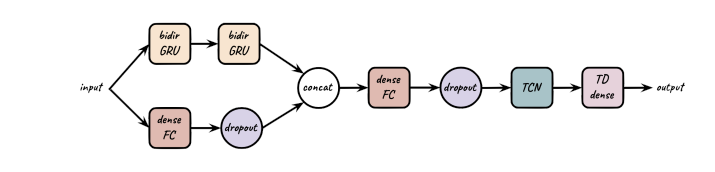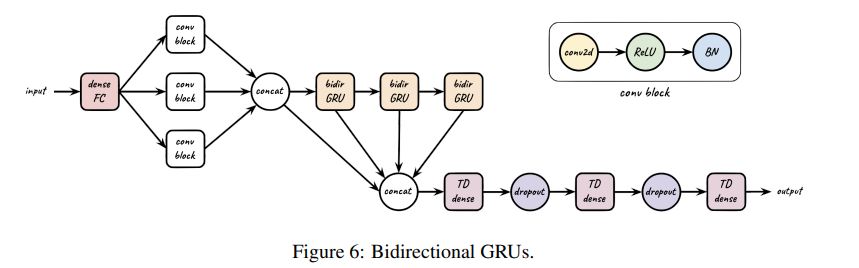)**

In [ ]:
import sys
# sys.path.append('keras-tcn')
from tcn import tcn
import h5py
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np 
import dill as pickle
import pandas as pd
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, CuDNNGRU
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Activation, RepeatVector, Permute
import tensorflow as tf
from keras.layers.merge import concatenate
from keras.layers import Dropout
from keras import regularizers
from keras.layers import merge
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.engine.topology import Layer

In [ ]:
class ProteinPredictor:
    def __init__(self, training_file, testing_file, data_directory):
        self.training_file = training_file
        self.testing_file = testing_file
        self.data_directory = data_directory
        self.encoder = Tokenizer()
        self.decoder = Tokenizer(char_level=True)
        self.sequence_length = 800
        self.network_model = None

    def load_datasets(self):
        try:
            self.training_data = pd.read_csv(self.training_file)
            self.testing_data = pd.read_csv(self.testing_file)
            self.training_array = np.load(f'{self.data_directory}/cb6133filtered.npy')
            self.testing_array = np.load(f'{self.data_directory}/cb513.npy')
        except Exception as error:
            print(f"Failed to load data: {error}")

    def process_data(self):
        try:
            inputs, targets = self.training_data[['input', 'expected']][self.training_data.len <= self.sequence_length].values.T
            input_ngrams = self.convert_to_ngrams(inputs)
            test_inputs = self.testing_data['input'].values.T
            test_ngrams = self.convert_to_ngrams(test_inputs)

            self.encoder.fit_on_texts(input_ngrams)
            self.decoder.fit_on_texts(targets)

            encoded_inputs = self.encoder.texts_to_sequences(input_ngrams)
            self.train_inputs = sequence.pad_sequences(encoded_inputs, maxlen=self.sequence_length, padding='post')
            encoded_targets = self.decoder.texts_to_sequences(targets)
            self.train_targets = sequence.pad_sequences(encoded_targets, maxlen=self.sequence_length, padding='post')
            self.train_targets = to_categorical(self.train_targets)

            encoded_test_inputs = self.encoder.texts_to_sequences(test_ngrams)
            self.test_inputs = sequence.pad_sequences(encoded_test_inputs, maxlen=self.sequence_length, padding='post')
        except Exception as error:
            print(f"Failed to process data: {error}")

    def construct_model(self):
        try:
            seq_input = Input(shape=(None,))
            profile_input = Input(shape=(None, 22))

            embed_x = Embedding(input_dim=len(self.encoder.word_index) + 1, output_dim=250)(seq_input)
            embed_x = concatenate([embed_x, profile_input], axis=2)

            gru_layer = Bidirectional(CuDNNGRU(units=500, return_sequences=True))(embed_x)
            gru_layer = Bidirectional(CuDNNGRU(units=100, return_sequences=True))(gru_layer)
            dense_layer = concatenate([embed_x, gru_layer])
            dense_output = Dense(500, activation="relu")(dense_layer)
            dense_output = Dropout(0.4)(dense_output)
            tcn_output = tcn.TCN()(dense_output)
            final_output = TimeDistributed(Dense(len(self.decoder.word_index) + 1, activation="softmax"))(tcn_output)

            self.network_model = Model([seq_input, profile_input], final_output)
            optimizer = Adam(lr=0.0025, beta_1=0.8, beta_2=0.8, decay=0.0001, amsgrad=False)
            self.network_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", self.custom_accuracy])
        except Exception as error:
            print(f"Failed to construct model: {error}")

    def execute_training(self):
        try:
            self.network_model.fit([self.train_inputs, self.training_profiles], self.train_targets, batch_size=30, epochs=6, verbose=1, shuffle=True)
        except Exception as error:
            print(f"Training failure: {error}")

    def predict_sequences(self):
        try:
            predictions = self.network_model.predict([self.test_inputs, self.testing_profiles])
            ids = self.testing_data['id'].values
            print('id,expected')
            for index, prediction in enumerate(predictions):
                self.display_results(ids[index], prediction, {value: key for key, value in self.decoder.word_index.items()})
        except Exception as error:
            print(f"Prediction error: {error}")

    def custom_accuracy(self, actual, predicted):
        actual_max = tf.argmax(actual, axis=-1)
        predicted_max = tf.argmax(predicted, axis=-1)
        mask = tf.greater(actual_max, 0)
        return K.cast(K.equal(tf.boolean_mask(actual_max, mask), tf.boolean_mask(predicted_max, mask)), K.floatx())

    def convert_to_ngrams(self, sequences, n=2):
        return np.array([[sequence[i:i + n] for i in range(len(sequence))] for sequence in sequences])

    def display_results(self, identifier, prediction, index_map):
        sequence = ''.join([index_map[np.argmax(prob)] for prob in prediction if np.max(prob) > 0])
        print(f'{identifier},{sequence}')


## **Bidirectional GRU with 2D Convolution**

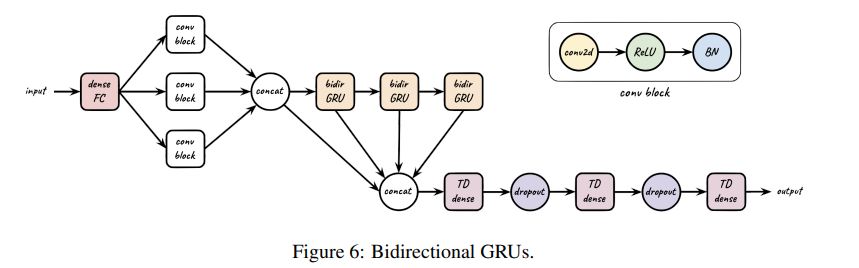

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.metrics import categorical_accuracy
from keras import backend as K
from sklearn.model_selection import KFold
import tensorflow as tf

In [ ]:
class ProteinStructureModel:
    def __init__(self, file_cb513, file_cb6133, file_cb6133_filtered):
        self.file_cb513 = file_cb513
        self.file_cb6133 = file_cb6133
        self.file_cb6133_filtered = file_cb6133_filtered

    def load_datasets(self):
        try:
            self.data_cb513 = np.load(self.file_cb513)
            self.data_cb6133 = np.load(self.file_cb6133)
            self.data_cb6133_filtered = np.load(self.file_cb6133_filtered)
        except Exception as e:
            print(f"Error loading datasets: {e}")

    def prepare_datasets(self):
        try:
            max_residue_length = 700
            alpha_fofe = 0.5  # FOFE encoding decay rate

            self.inputs_filtered = self.data_cb6133_filtered.reshape(5534, max_residue_length, 57)
            self.outputs_filtered = self.inputs_filtered[:, :, 22:31]
            self.inputs_onehot = self.inputs_filtered[:, :, :22]
            self.inputs_encoded = np.array([self.fofe_encode(x, alpha_fofe, max_residue_length) for x in self.inputs_onehot])

            self.inputs_cb513 = self.data_cb513.reshape(514, max_residue_length, 57)
            self.inputs_cb513_onehot = self.inputs_cb513[:, :, :22]
            self.inputs_cb513_encoded = np.array([self.fofe_encode(x, alpha_fofe, max_residue_length) for x in self.inputs_cb513_onehot])

        except Exception as e:
            print(f"Error preparing datasets: {e}")

    def fofe_encode(self, sequence, alpha, maxlen):
        encoded = np.zeros((maxlen, 2 * 22))
        encoded[0, :22] = sequence[0]
        encoded[maxlen-1, 22:] = sequence[maxlen-1]
        for i in range(1, maxlen):
            encoded[i, :22] = encoded[i-1, :22] * alpha + sequence[i]
            encoded[maxlen-i-1, 22:] = encoded[maxlen-i, 22:] * alpha + sequence[maxlen-i-1]
        return encoded

    def build_network(self, num_features, num_classes):
        try:
            input_layer = Input(shape=(700, num_features))
            x = Dense(128, activation='relu')(input_layer)
            x = Reshape([700, 128, 1])(x)

            conv_blocks = []
            for k_size in [3, 7, 11]:
                conv_layer = ZeroPadding2D(((k_size // 2, 0), (0, 0)))(x)
                conv_layer = Conv2D(64, (k_size, 128), activation='relu')(conv_layer)
                conv_layer = BatchNormalization()(conv_layer)
                conv_blocks.append(conv_layer)

            concatenated_conv = concatenate(conv_blocks)
            concatenated_conv = Reshape([700, 192])(concatenated_conv)

            bi_gru = concatenated_conv
            for _ in range(3):
                bi_gru = Bidirectional(GRU(32, return_sequences=True, activation='tanh', recurrent_activation='hard_sigmoid'))(bi_gru)

            fully_connected = TimeDistributed(Dense(256, activation='relu'))(bi_gru)
            fully_connected = Dropout(0.1)(fully_connected)
            fully_connected = TimeDistributed(Dense(128, activation='relu'))(fully_connected)
            fully_connected = Dropout(0.1)(fully_connected)

            output_layer = TimeDistributed(Dense(num_classes, activation='softmax'))(fully_connected)
            self.model = Model(input_layer, output_layer)
            self.model.compile(optimizer=nadam(), loss='categorical_crossentropy', metrics=['accuracy'])
            self.model.summary()
        except Exception as e:
            print(f"Error building network model: {e}")

    def train_and_predict(self, train_inputs, train_targets, test_inputs):
        try:
            self.model.fit(train_inputs, train_targets, batch_size=64, epochs=12, verbose=1)
            predictions = self.model.predict(test_inputs)
            return predictions
        except Exception as e:
            print(f"Error during training and prediction: {e}")

    def save_predictions(self, predictions, output_path):
        try:
            predicted_sequences = self.convert_to_sequences(predictions)
            result_df = pd.DataFrame({'id': np.arange(1, len(predictions) + 1), 'prediction': predicted_sequences})
            result_df.to_csv(output_path, index=False)
        except Exception as e:
            print(f"Error saving predictions: {e}")

    def convert_to_sequences(self, predictions):
        structure_types = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T', 'NoSeq']
        return [''.join([structure_types[np.argmax(res)] for res in pred]) for pred in predictions]


In [ ]:
obj = ProteinStructureModel('cb513.npy', 'cb6133.npy', 'cb6133filtered.npy')
obj.load_datasets()
obj.build_network(22, 9)
obj.train_and_predict(obj.inputs_encoded, obj.outputs_filtered, obj.inputs_cb513_encoded)
obj.save_predictions(obj.inputs_cb513_encoded, 'output.csv')
